#### References
- [DeepSDF: Learning Continuous SDF Functions for Shape Recognition](https://arxiv.org/pdf/1901.05103.pdf)
- [deepSDF-explained](https://github.com/Oktosha/DeepSDF-explained/blob/master/deepSDF-explained.ipynb)

In [126]:
import os
import typing as typ
import numpy as np
import matplotlib.pyplot as plt
import functools
import datetime

In [127]:
RANDOM_SEED = 0

In [128]:
np.random.seed(RANDOM_SEED)

### 3D shape representation approaches
#### Point clouds  (ex: Lidar sensors)
- **cons**: continious surface, not suitable for producing watertight* surfaces
- reference: [PointNet](https://github.com/charlesq34/pointnet) (**TODO**)

#### Meshes (ex: triangles)
- **cons**: model shapes only with fixed mesh topology (hard to produce closed shape, parameters tuning: cutting algorithm)

#### Voxel Grid (ex: 3D occupancy grid)
- each cell contains: occupied or not
- **cons**: heavy computation, memory usage (128^3 max)

#### Voxel SDF
- each cell contains: SDF value
- **cons**: discrete (low resolution)


- **Watertight** is a term used to describe a 3D mesh suitable for 3D Printing [source](https://mechsolutions.com/3d-printing/required-reading/)



### SDF
- **signed distance function** (SDF) is a **continuous** function that, **for a given spatial point, outputs the point’s distance to the closest surface**, whose sign encodes whether the point **is inside (negative)** or **outside (positive)** of the watertight surface.
- **zero iso-surface** when SDF(x) = 0 (exact surface location)


### Modeling SDF with NNs
- directly **regress** the **continuous SDF from point samples**
- the resulting **trained network** is able to **predict** the **SDF value** of a **given query position**, from which we can extract the zero level-set surface by evaluating spatial samples. 

### Single Shape SDF

#### 1. Data Preparation
- given a target shape, prepare a **set of pairs X**, composed of 3D point samples (**[x, y, z]**) and their **SDF values**.

##### Additional

- **normalize to a unit sphere** (in practice fit to sphere radius of 1/1.03)
- sample N (ex: 500 000) spatial points (more aggresive **near surface**, to capture details)


In [129]:
Point = typ.Union[np.ndarray, list]

In [130]:
class Shape:
    def sdf(self, p: Point) -> float:
        pass    
    
class Circle(Shape):
    
    def __init__(self, center: Point, radius: float):
        self._center = np.float_(center)
        self._radius = radius
    
    def sdf(self, p: Point) -> float:
        return np.linalg.norm(np.float_(p) - self._center) - self._radius

In [131]:
def plot_heatmap(x: np.ndarray, y: np.ndarray, z: np.ndarray, plot_colorbar: bool = True):
    """Plots heatmap 
    
    :param x: [h, w]
    :param y: [h, w]
    :param z: [h, w]
    """
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot()
    
    z_min, z_max = -np.abs(z).max(), np.abs(z).max()
    c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
    ax.axis([x.min(), x.max(), y.min(), y.max()])
        
    if plot_colorbar:
        cbaxes = fig.add_axes([0.93, 0.12, 0.03, 0.76]) 
        fig.colorbar(c, cax=cbaxes)

def plot_heatmap_sdf(sdf_func: typ.Callable[[Point], float], size:int = 100, plot_colorbar: bool = True):
    """Plots heatmap of sdf values"""
    # See https://stackoverflow.com/questions/33282368/plotting-a-2d-heatmap-with-matplotlib
    linspace = np.linspace(-1, 1, size)
    y, x = np.meshgrid(linspace, linspace)
    sdfs = np.float_([[sdf_func([x_, y_]) for y_ in  linspace] for x_ in linspace])
    
    plot_heatmap(x, y, sdfs, plot_colorbar)


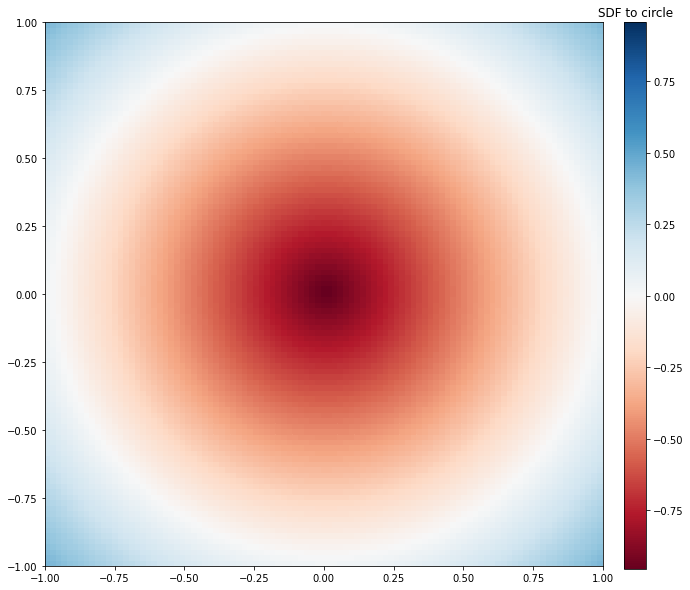

In [132]:
# Check heatmap with simple shape
RADIUS = 1 / 1.03 # fit to circle radius of 1/1.03 (unit sphere)
circle = Circle(center=[0, 0], radius=RADIUS)
plot_heatmap_sdf(circle.sdf)
plt.title("SDF to circle")
plt.show()

In [133]:
from sklearn.model_selection import train_test_split

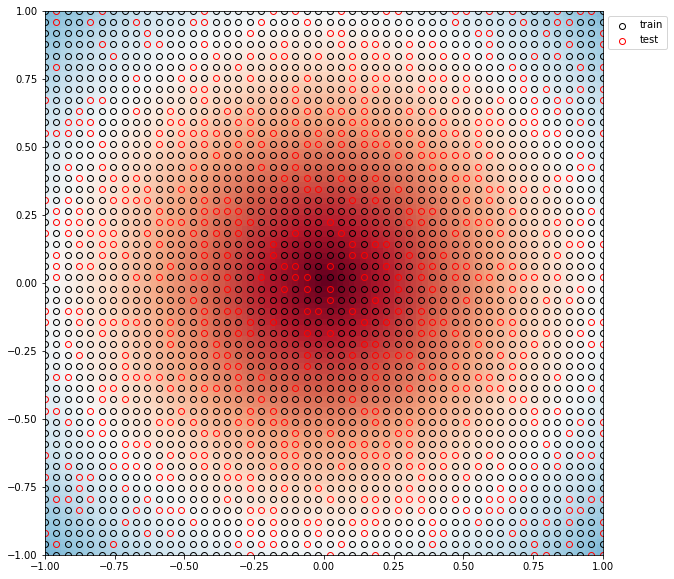

In [134]:
# Sample points
RESOLUTION = 100
SAMPLE_SIZE = 50
linspace = np.linspace(-1, 1, SAMPLE_SIZE)  # unit_shape

points = [[x_, y_] for y_ in  linspace for x_ in linspace]
sdfs = list(map(circle.sdf, points))

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
X_train, X_test, Y_train, Y_test = list(map(np.float_, 
                                            train_test_split(points, sdfs, test_size=0.25, random_state=42)))

plot_heatmap_sdf(circle.sdf, size=RESOLUTION, plot_colorbar=False)
ax_train = plt.scatter(X_train[:,0], X_train[:,1], color=(1, 1, 1, 0), edgecolor='black', label='train')
ax_test = plt.scatter(X_test[:,0], X_test[:,1], color=(1, 1, 1, 0), edgecolor='red', label='test')
plt.legend(handles=[ax_train, ax_test], bbox_to_anchor=(1, 1))
plt.show()

#### 2. Network Architecture
- **8 fully connected** layers (**512 neurons** each)
- **dropout (0.2)** (except last)
- **RELU** (last: **tanh**)
- **skip connections** (4-th layer)
- **weight normalization** (because batch normalization is unstable)
- **ADAM** optimizer

In [135]:
import torch.nn as nn
import torch
import torch.nn.functional as F

In [136]:
# Reproducibility best practices: 
# https://pytorch.org/docs/stable/notes/randomness.html
torch.manual_seed(0)

In [137]:
# Initial implementation:
# https://github.com/facebookresearch/DeepSDF/blob/master/networks/deep_sdf_decoder.py
class Decoder(nn.Module):
    def __init__(
        self,
        latent_size: int,
        dims: typ.List[int],
        two_d: bool = False,
        dropout: typ.List[int]=None,
        dropout_prob:float=0.0,
        norm_layers: typ.List[int]=(),
        latent_in=(),
        weight_norm: bool = False,
        xyz_in_all: bool = None,
        use_tanh: bool = False,
        latent_dropout: bool =False,
    ):
        """
        :param latent_size: size of latent vector Z (shape code) (ex.: 256, 128)
        :param dims: num of neurons per each layer (ex.: [512] * 8)
        :param two_d: if True use (x, y), else (x, y, z)
        :param dropout: layer indexes with dropout enabled
        :param dropout_prob: [0.0, 1.0]
        :param norm_layers: layer indexes with weight normalization enabled
        :param latent_in: layer index with latent vector skip connection
        """
        super(Decoder, self).__init__()

        def make_sequence():
            return []
        
        self.n_points = 2 if two_d else 3 
        dims = [latent_size + self.n_points] + dims + [1]

        self.num_layers = len(dims)
        self.norm_layers = norm_layers
        self.latent_in = latent_in
        self.latent_dropout = latent_dropout
        if self.latent_dropout:
            self.lat_dp = nn.Dropout(0.2)

        self.xyz_in_all = xyz_in_all
        self.weight_norm = weight_norm

        for layer in range(0, self.num_layers - 1):
            if layer + 1 in latent_in:
                out_dim = dims[layer + 1] - dims[0]
            else:
                out_dim = dims[layer + 1]
                if self.xyz_in_all and layer != self.num_layers - 2:
                    out_dim -= self.n_points

            if weight_norm and layer in self.norm_layers:
                setattr(
                    self,
                    "lin" + str(layer),
                    nn.utils.weight_norm(nn.Linear(dims[layer], out_dim)),
                )
            else:
                setattr(self, "lin" + str(layer), nn.Linear(dims[layer], out_dim))

            if (
                (not weight_norm)
                and self.norm_layers is not None
                and layer in self.norm_layers
            ):
                setattr(self, "bn" + str(layer), nn.LayerNorm(out_dim))

        self.use_tanh = use_tanh
        if use_tanh:
            self.tanh = nn.Tanh()
        self.relu = nn.ReLU()

        self.dropout_prob = dropout_prob
        self.dropout = dropout
        self.th = nn.Tanh()

    def forward(self, input: torch.Tensor) -> float:
        """
        :param input: [N, latent_size + n_points]
        
        :rtype: sdf value
        """
        xyz = input[:, -self.n_points:]

        if input.shape[1] > self.n_points and self.latent_dropout:
            latent_vecs = input[:, :-self.n_points]
            latent_vecs = F.dropout(latent_vecs, p=0.2, training=self.training)
            x = torch.cat([latent_vecs, xyz], 1)
        else:
            x = input

        for layer in range(0, self.num_layers - 1):
            lin = getattr(self, "lin" + str(layer))
            if layer in self.latent_in:
                x = torch.cat([x, input], 1)
            elif layer != 0 and self.xyz_in_all:
                x = torch.cat([x, xyz], 1)
            x = lin(x)
            # last layer Tanh
            if layer == self.num_layers - 2 and self.use_tanh:
                x = self.tanh(x)
            if layer < self.num_layers - 2:
                if (
                    self.norm_layers is not None
                    and layer in self.norm_layers
                    and not self.weight_norm
                ):
                    bn = getattr(self, "bn" + str(layer))
                    x = bn(x)
                x = self.relu(x)
                if self.training and self.dropout is not None and layer in self.dropout:
                    x = F.dropout(x, p=self.dropout_prob, training=self.training)

        if hasattr(self, "th"):
            x = self.th(x)

        return x

In [138]:
def is_cuda(model: torch.nn.Module) -> bool:
    """
    https://discuss.pytorch.org/t/how-to-check-if-model-is-on-cuda/180
    """
    return next(model.parameters()).is_cuda

In [197]:
NUM_LAYERS = 8
NUM_NEURONS = 512

# initialize model
# https://github.com/facebookresearch/DeepSDF/blob/master/examples/chairs/specs.json
CONFIG = {
    "two_d": True,
    "latent_size": 0, 
    "dims": [512] * 8,                       # [NUM_NEURONS] * NUM_LAYERS
    "dropout": [0, 1, 2, 3, 4, 5, 6, 7],     # list(range(0, NUM_LAYERS))
    "dropout_prob": 0.2,
    "norm_layers": [0, 1, 2, 3, 4, 5, 6, 7], # list(range(0, NUM_LAYERS))
    "latent_in": [],
    "xyz_in_all": False,
    "use_tanh": False,
    "latent_dropout": False,
    "weight_norm": True
}

model = Decoder(**CONFIG)
# print model to see architecture
model

Decoder(
  (lin0): Linear(in_features=2, out_features=512, bias=True)
  (lin1): Linear(in_features=512, out_features=512, bias=True)
  (lin2): Linear(in_features=512, out_features=512, bias=True)
  (lin3): Linear(in_features=512, out_features=512, bias=True)
  (lin4): Linear(in_features=512, out_features=512, bias=True)
  (lin5): Linear(in_features=512, out_features=512, bias=True)
  (lin6): Linear(in_features=512, out_features=512, bias=True)
  (lin7): Linear(in_features=512, out_features=512, bias=True)
  (lin8): Linear(in_features=512, out_features=1, bias=True)
  (relu): ReLU()
  (th): Tanh()
)

In [198]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [189]:
model = model.to(device)
use_cuda = is_cuda(model)
print("Model placed on: ", "CUDA" if use_cuda else "CPU")

Model placed on:  CUDA


In [190]:
# check forward pass
data = torch.FloatTensor([[1, 2]])
model.eval()
model.forward(data.to(device))

tensor([[0.0061]], device='cuda:0', grad_fn=<TanhBackward>)

In [143]:
import torchsummary

In [144]:
torchsummary.summary(model, (1, 2))

------------------------------------------------------------------------------------------
Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 1, 512]              2,048
├─ReLU: 1-2                              [-1, 1, 512]              --
├─Linear: 1-3                            [-1, 1, 512]              263,168
├─ReLU: 1-4                              [-1, 1, 512]              --
├─Linear: 1-5                            [-1, 1, 512]              263,168
├─ReLU: 1-6                              [-1, 1, 512]              --
├─Linear: 1-7                            [-1, 1, 512]              263,168
├─ReLU: 1-8                              [-1, 1, 512]              --
├─Linear: 1-9                            [-1, 1, 512]              263,168
├─ReLU: 1-10                             [-1, 1, 512]              --
├─Linear: 1-11                           [-1, 1, 512]              263,168
├─ReLU: 1-12                        

------------------------------------------------------------------------------------------
Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 1, 512]              2,048
├─ReLU: 1-2                              [-1, 1, 512]              --
├─Linear: 1-3                            [-1, 1, 512]              263,168
├─ReLU: 1-4                              [-1, 1, 512]              --
├─Linear: 1-5                            [-1, 1, 512]              263,168
├─ReLU: 1-6                              [-1, 1, 512]              --
├─Linear: 1-7                            [-1, 1, 512]              263,168
├─ReLU: 1-8                              [-1, 1, 512]              --
├─Linear: 1-9                            [-1, 1, 512]              263,168
├─ReLU: 1-10                             [-1, 1, 512]              --
├─Linear: 1-11                           [-1, 1, 512]              263,168
├─ReLU: 1-12                        

###  Training
#### Loss
- **L2**
$$ L(net(x), sdf_{target}) =  (net(x) - sdf_{target})^2$$

- **L1** (clamped)

$$ L(net(x), sdf_{target}) = |clamp(net(x), \delta) - clamp(sdf_{target}, \delta)| $$
$$ clamp(x, \delta) = min(\delta, max(x, -\delta)) $$

- used in paper:      
$$ \delta = 0.1 $$

In [180]:
# Learning rate schedulers:
# https://github.com/facebookresearch/DeepSDF/blob/master/train_deep_sdf.py#L18
class LearningRateSchedule:
    def get_learning_rate(self, epoch: int) -> float:
        pass


class ConstantLearningRateSchedule(LearningRateSchedule):
    def __init__(self, value: float):
        self.value = value

    def get_learning_rate(self, epoch: int) -> float:
        return self.value


class StepLearningRateSchedule(LearningRateSchedule):
    def __init__(self, initial: float, interval: int, factor: float):
        self.initial = initial
        self.interval = interval
        self.factor = factor

    def get_learning_rate(self, epoch: int) -> float:
        return self.initial * (self.factor ** (epoch // self.interval))

In [181]:
from torch.utils.data import TensorDataset, DataLoader
from livelossplot import PlotLosses

In [182]:
# data loaders: https://pytorch.org/docs/stable/data.html
# train_ds = TensorDataset(torch.Tensor(points_train), torch.Tensor(sdf_train))
# train_dl = DataLoader(train_ds, shuffle=True, batch_size=len(train_ds))

trainloader = DataLoader(TensorDataset(torch.Tensor(X_train), torch.Tensor(Y_train)),
                         batch_size=len(X_train), shuffle=True)
testloader = DataLoader(TensorDataset(torch.Tensor(X_test), torch.Tensor(Y_test)),
                         batch_size=len(X_test), shuffle=False)

dataloaders = {
    "train": trainloader,
    "validation": testloader
}

In [183]:
EXPERIMENTS_DIR = os.path.abspath("../experiments")

In [184]:
def save_model(filename: str, model: torch.nn.Module):
    torch.save(model.state_dict(),  filename)
    print(f"Saved to {filename}")

def save_checkpoints(directory:str, epoch: int, model: torch.nn.Module):
    save_model(os.path.join(directory, str(epoch) + ".pth"), model)
    
def load_model_from_file(filename: str, config: dict, device: str = "cpu") -> nn.Module:
    model = Decoder(**config)
    model = model.to(device)
    model.load_state_dict(torch.load(filename))
    return model

In [191]:
SDF_TOLERANCE = 1e-1

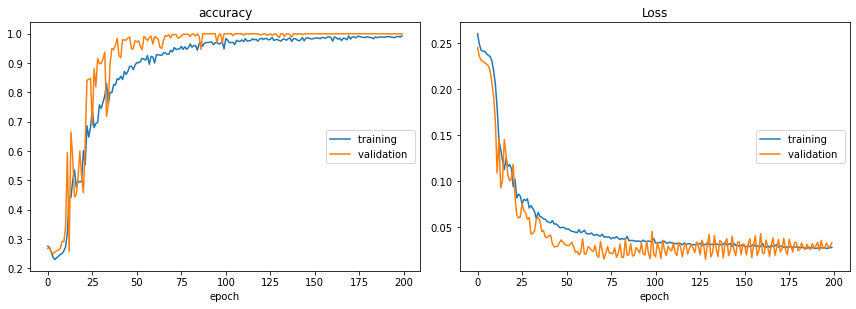

accuracy
	training         	 (min:    0.230, max:    0.993, cur:    0.993)
	validation       	 (min:    0.250, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    0.027, max:    0.260, cur:    0.028)
	validation       	 (min:    0.015, max:    0.245, cur:    0.033)


In [199]:
# example:
# https://github.com/stared/livelossplot/blob/master/examples/pytorch.ipynb
liveloss = PlotLosses()

model = model.to(device)

epochs = 200
save_each = 50

experiments_dir = os.path.join(EXPERIMENTS_DIR, 
                               datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S"))
os.makedirs(experiments_dir)

# source: 
# https://github.com/facebookresearch/DeepSDF/blob/master/train_deep_sdf.py#L378
# api: https://pytorch.org/docs/master/generated/torch.nn.L1Loss.html
loss_l1 = torch.nn.L1Loss(reduction="sum")

# learning parameters:
# https://github.com/facebookresearch/DeepSDF/blob/master/examples/chairs/specs.json#L23
learning_rate = 0.0005 # initial
learning_rate_schedule = StepLearningRateSchedule(initial=learning_rate, interval=500, factor=0.5)

# api: https://pytorch.org/docs/stable/optim.html
optimizer = torch.optim.Adam([
    {
        "params": model.parameters(),
        "lr": learning_rate_schedule.get_learning_rate(0),  # TODO: use learning rate scheduler
    }
])

# Use to build heatmaps
linspace = np.linspace(-1, 1, RESOLUTION)
y_grid, x_grid = np.meshgrid(linspace, linspace)
grid_coords_np = np.array([y_grid, x_grid]).T.reshape(-1, 2)
grid_coords = torch.from_numpy(grid_coords_np).float()  # Use to plot heatmap
heatmaps = []

logs = {}

for epoch in range(epochs):
    logs = {}
    
    # update learning rate
    # With constant learning rate plato observed
    optimizer.param_groups[0]["lr"] = learning_rate_schedule.get_learning_rate(epoch)
    
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)     # [batch_size, 1]
            outputs = outputs.squeeze() # [batch_size]
            
            # l1 loss (TODO: -> clamped)
            loss = F.l1_loss(outputs, labels)

            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            running_loss += loss.detach() * inputs.size(0)
            
            abs_error = torch.abs(outputs - labels)
            # assume correct SDF values wrt tolerance value
            running_corrects += torch.sum(abs_error < SDF_TOLERANCE)

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)
            
        prefix = ''
        if phase == 'validation':
            prefix = 'val_'

        logs[prefix + 'loss'] = epoch_loss.item()
        logs[prefix + 'accuracy'] = epoch_acc.item()
        
    if epoch % save_each == 0:
        outputs = model.forward(grid_coords.to(device))
            
        heatmaps.append({
            "epoch" : epoch,
            "out": outputs.cpu().detach().numpy().reshape(RESOLUTION, RESOLUTION)
        })
        save_checkpoints(experiments_dir, epoch, model) 
        
    liveloss.update(logs)
    liveloss.send() 

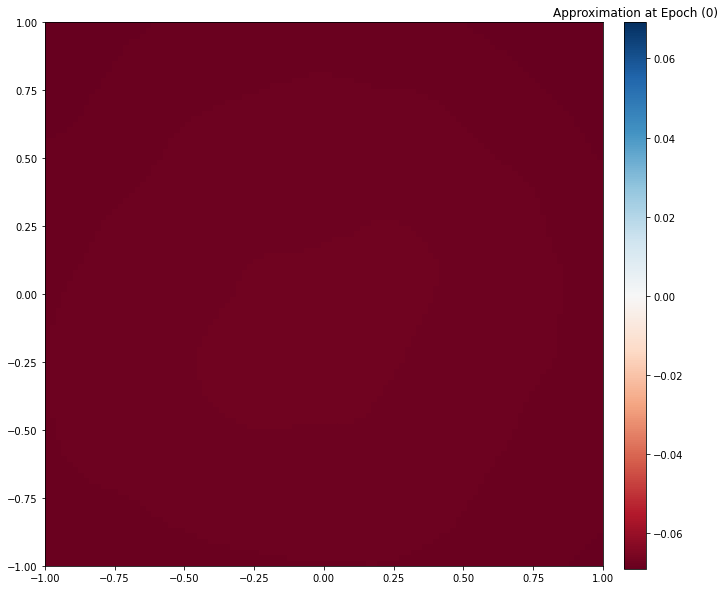

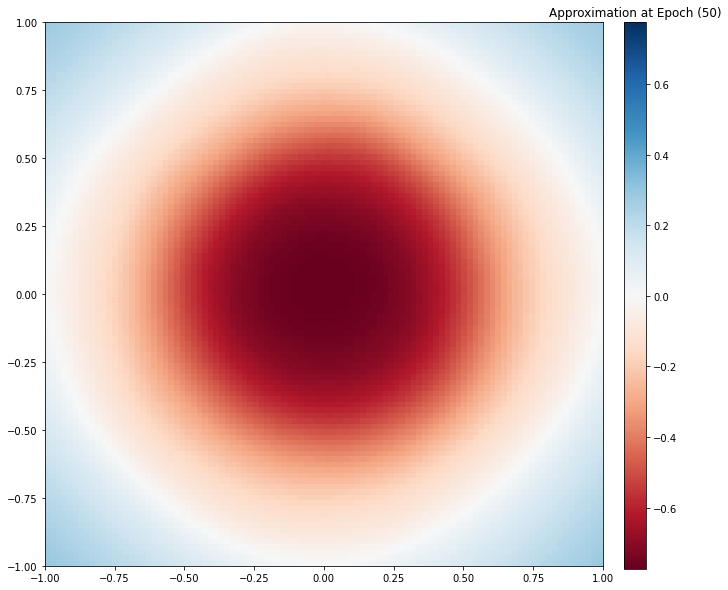

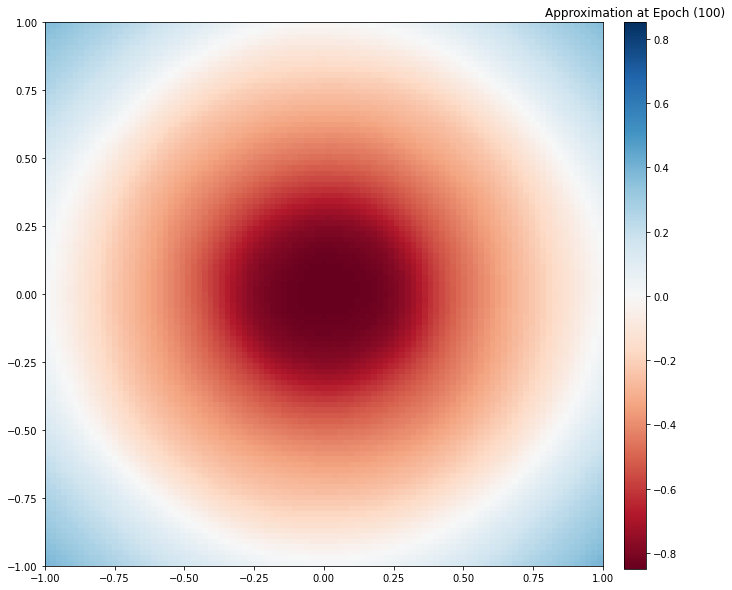

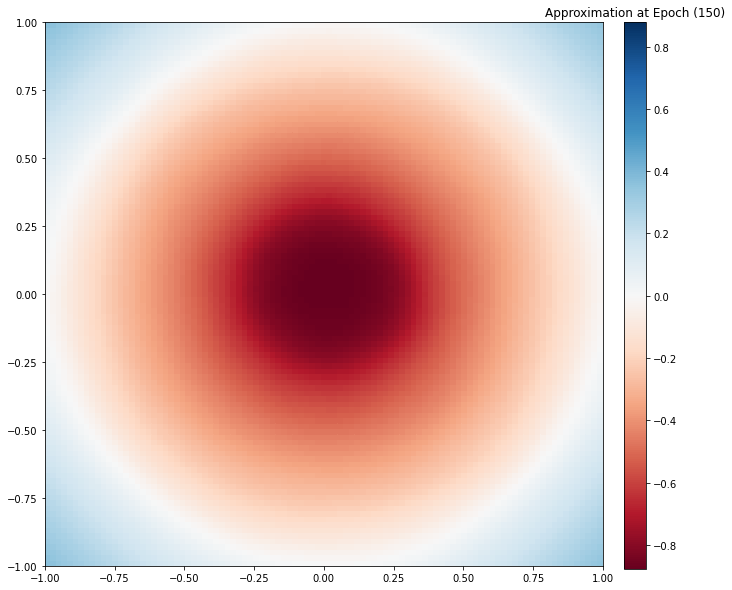

In [200]:
# Plot heatmap updates each epoch
for heatmap in heatmaps:
    plot_heatmap(x_grid, y_grid, heatmap['out'])
    plt.title(f"Approximation at Epoch ({heatmap['epoch']})")
    plt.show()

In [201]:
save_model(os.path.join(EXPERIMENTS_DIR, "final.pth"), model)

Saved to final.pth


### Inference

In [210]:
!nvidia-smi

Mon Jun 29 13:43:05 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.00    Driver Version: 418.87.00    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1050    On   | 00000000:01:00.0  On |                  N/A |
| N/A   65C    P8    N/A /  N/A |   2385MiB /  4040MiB |     14%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [212]:
! cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 158
model name	: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz
stepping	: 9
microcode	: 0xd6
cpu MHz		: 3548.565
cache size	: 6144 KB
physical id	: 0
siblings	: 8
core id		: 0
cpu cores	: 4
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 22
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc art arch_perfmon pebs bts rep_good nopl xtopology nonstop_tsc cpuid aperfmperf pni pclmulqdq dtes64 monitor ds_cpl vmx est tm2 ssse3 sdbg fma cx16 xtpr pdcm pcid sse4_1 sse4_2 x2apic movbe popcnt tsc_deadline_timer aes xsave avx f16c rdrand lahf_lm abm 3dnowprefetch cpuid_fault epb invpcid_single pti ssbd ibrs ibpb stibp tpr_shadow vnmi flexpriority ept vpid fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid mpx rdseed adx smap clflushopt intel_pt xsaveopt xsavec xgetbv1 xsaves dtherm

In [207]:
test_model = load_model_from_file(os.path.join(EXPERIMENTS_DIR, "final.pth"), CONFIG, device)


In [208]:
linspace = np.linspace(-1, 1, RESOLUTION)
y_grid, x_grid = np.meshgrid(linspace, linspace)
grid_coords_np = np.array([y_grid, x_grid]).T.reshape(-1, 2)
grid_coords = torch.from_numpy(grid_coords_np).float()  # Use to plot heatmap

In [209]:
%%time
test_model.forward(grid_coords.to(device))

CPU times: user 2.71 ms, sys: 0 ns, total: 2.71 ms
Wall time: 1.91 ms


tensor([[0.3483],
        [0.4383],
        [0.4141],
        ...,
        [0.4026],
        [0.2945],
        [0.4444]], device='cuda:0', grad_fn=<TanhBackward>)

In [213]:
print(grid_coords.shape)

torch.Size([10000, 2])
